In [ ]:
#pip install ee

In [ ]:
#pip install geemap

# Import Libraries

In [141]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [142]:
target_lakes = [
    'Avalanche Lake', 'Big Moose Lake', 'Black Pond', 'Carry Pond',
    'Cascade Lake', 'Clear Pond', 'Dart Lake', 'G Lake',
    'Grass Pond', 'Heart Lake', 'Indian Lake', 'Jockeybush Lake',
    'Lake Colden', 'Lake Rondaxe', 'Limekiln Lake', 'Little Clear Pond',
    'Little Hope Pond', 'Little Simon Pond', 'Long Pond', 'Lost Pond',
    'Middle Branch Lake', 'Middle Pond', 'Middle Settlement Lake', 'Moss Lake',
    'Nate Pond', 'North Lake', 'Owen Pond', 'Queer Lake', 'Raquette Lake Reservoir',
    'Sagamore Lake', 'Squaw Lake', 'Willys Lake', 'Woods Lake'
]

In [143]:
# Read the Excel files
data_excel = pd.read_excel("LTM_Data_2023_3_9.xlsx", usecols=['DOC_MG_L', 'SITE_ID', 'DATE_SMP'])
data_excel_site = pd.read_excel("Site_Information_2022_8_1 (2).xlsx", usecols=['SITE_ID', 'PROGRAM_ID', 'SITE_NAME'])

# Filter rows based on specific SITE_ID value for a given lake name
def get_doc_values_by_lake_name(lake_name):
    # Filter the site data by PROGRAM_ID 'LTM_ALTM'
    data_excel_site_filtered = data_excel_site[data_excel_site['PROGRAM_ID'] == 'LTM_ALTM']
   
    # Get the specific SITE_ID for the given lake name
    specific_site_id = data_excel_site_filtered[data_excel_site_filtered['SITE_NAME'] == lake_name]['SITE_ID'].iloc[0]
   
    # Filter the data based on the specific SITE_ID
    data_excel_filtered = data_excel[data_excel['SITE_ID'] == specific_site_id]

    # Drop rows with null values
    data_excel_filtered = data_excel_filtered.dropna()

    # Rename columns
    data_excel_filtered = data_excel_filtered.rename(columns={'DATE_SMP': 'date', 'DOC_MG_L': 'DOC'})

    # Filter data from 2016 onwards
    data_excel_filtered = data_excel_filtered[data_excel_filtered['date'] >= '2019-01-01']

    # Sort the DataFrame by date in ascending order
    data_excel_filtered = data_excel_filtered.sort_values('date')
   
   
    return data_excel_filtered





Big Moose Lake
DOC values for Big Moose Lake:
       SITE_ID       date       DOC
18861  1A1-103 2019-02-05  7.659300
38335  1A1-103 2019-04-02  6.400300
37120  1A1-103 2019-05-01  5.958300
16544  1A1-103 2019-07-09  5.888300
1887   1A1-103 2019-09-04  5.505700
38346  1A1-103 2019-11-14  7.429081
37128  1A1-103 2020-02-03  7.373080
5568   1A1-103 2020-05-28  5.758763
32198  1A1-103 2020-07-14  5.007855
16554  1A1-103 2020-09-01  4.970554
3125   1A1-103 2020-11-05  5.042800
28525  1A1-103 2021-02-03  6.499600
34632  1A1-103 2021-04-01  7.029300
1901   1A1-103 2021-05-04  6.989800
8040   1A1-103 2021-07-15  5.821500
11687  1A1-103 2021-09-02  7.912200


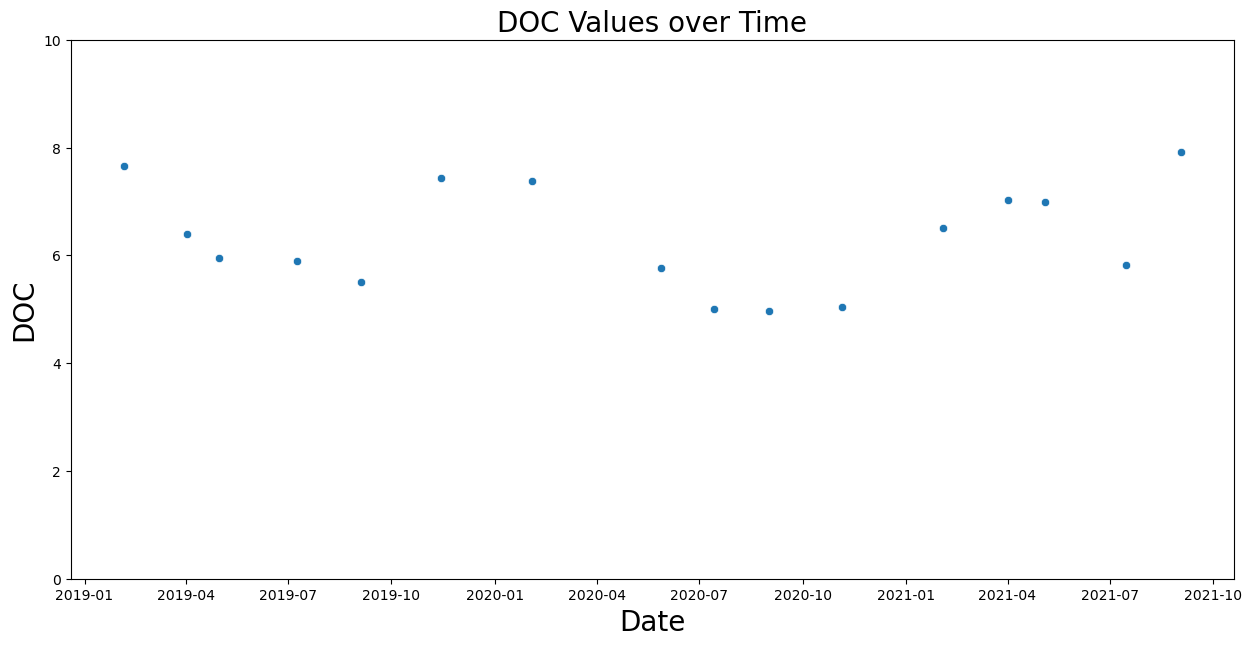

In [144]:
# Enter the lake name to get the corresponding DOC values
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

lake_name = input("")


                  
data = get_doc_values_by_lake_name(lake_name)

# Print the DOC values for the lake
print(f"DOC values for {lake_name}:")
with pd.option_context('display.max_rows', None):
    print(data)
# Convert the 'date' column to a datetime type
data['date'] = pd.to_datetime(data['date'])

# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=data, x=data['date'], y='DOC', ax=ax)

# Set the labels and title
ax.set_ylabel('DOC', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('DOC Values over Time', fontsize=20)
ax.set_ylim(0, 10)

# Format the x-axis tick labels to display only the year


# Display the plot
plt.show()








In [145]:
lake = ee.FeatureCollection('projects/ee-touheda-khanom/assets/samplinglakes') \
    .filter(ee.Filter.eq('GNIS_Name', f'{lake_name}'))


In [146]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage

In [147]:
sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

In [148]:
# Function to calculate CDOM from Sentinel-2 images
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1': img.select('Aerosols'),
        'b2': img.select('Blue'),
        'b3': img.select('Green'),
        'b4': img.select('Red')
    }).rename("CO")
    
    bad2 = cdo.where(cdo.gte(0), 1).rename("bad2")
    co = cdo.multiply(bad2).rename("CO")
    mask = co.neq(0)

    return img.addBands(co).clip(lake).updateMask(mask)

In [149]:
#
# Load Sentinel-2 data and apply the processing steps for the lake
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(2019, 2023, 'year')) \
    .filterBounds(lake) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))\
    .map(cdom)

In [150]:
s2_image = ee.Image(s2.first())

# Get band names of the first image
band_names = s2_image.bandNames().getInfo()

# Print the band names
print(band_names)

['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'CO']


# Masking Clouds

In [151]:
#Map.user_roi.getInfo()

In [152]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [153]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

# CDOM

In [154]:
def station_mean(img): # station_mean function with a single parameter img
    #mean of a specific band (CO) within a region 
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).get('CO')
    return img.set('date', img.date().format()).set('CDOM',mean)

station_reduced_imgs = s2.map(station_mean)
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','CDOM']).values().get(0)
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])

df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])
pd.set_option('display.max_rows', None)

df


,date,CDOM
0,2019-01-11T16:01:03,7.073957
1,2019-03-27T16:01:07,7.876151
2,2019-03-27T16:01:03,7.884210
3,2019-04-16T16:01:10,7.992020
4,2019-04-16T16:01:06,8.008363
5,2019-05-06T16:01:11,6.929021
6,2019-05-06T16:01:08,5.421134
7,2019-05-16T16:01:11,5.569435
8,2019-05-16T16:01:08,5.466830
9,2019-05-26T16:01:10,8.000575


In [155]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,CDOM
0,2019-01-11,7.073957
1,2019-03-27,7.876151
2,2019-03-27,7.884210
3,2019-04-16,7.992020
4,2019-04-16,8.008363
5,2019-05-06,6.929021
6,2019-05-06,5.421134
7,2019-05-16,5.569435
8,2019-05-16,5.466830
9,2019-05-26,8.000575


In [156]:
# import pandas as pd

# # Filter out CDOM values greater than 20
# df = df[df['CDOM'] <= 20]


# df

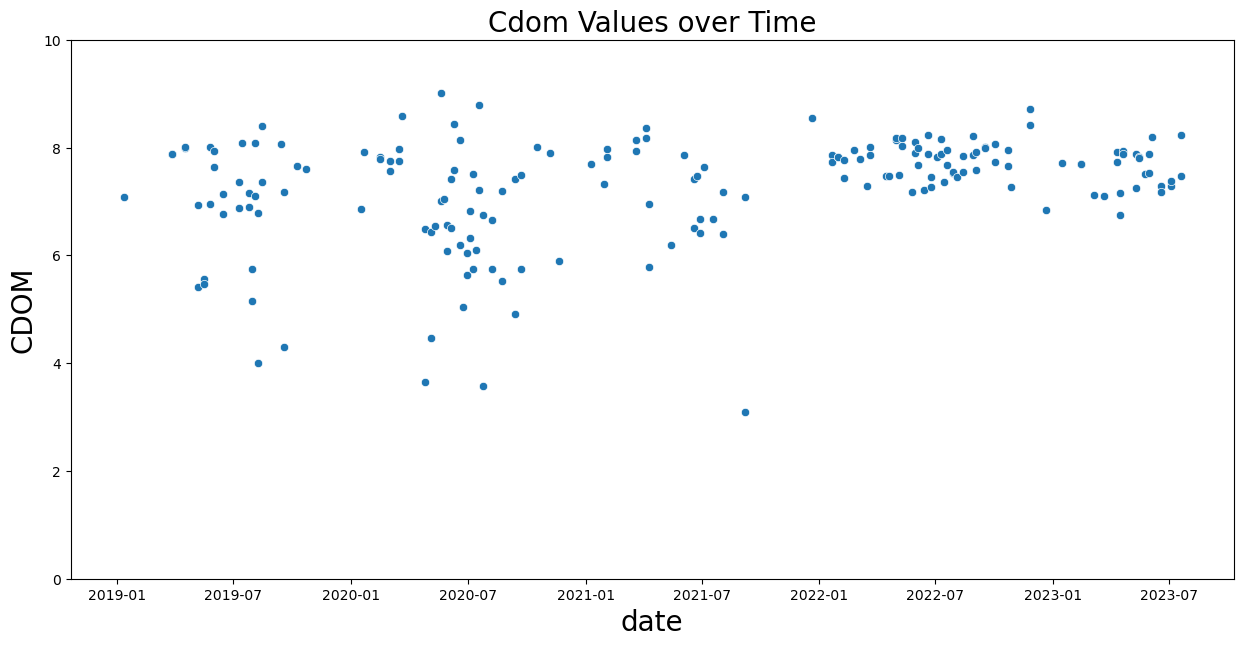

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)
ax.set_ylim(0,10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


# DOC

In [158]:
# import pandas as pd

# # Read the data from the Excel file
# data_doc = pd.read_excel('LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L', 'SITE_ID', 'DATE_SMP'])

# data_doc = data_doc[data_doc['DOC_MG_L'].notnull()]

# # Sort the DataFrame by 'DATE_SMP' column in ascending order
# data_doc = data_doc.sort_values(by='DATE_SMP')

# # Filter data from 2016 onwards
# data_doc = data_doc[data_doc['DATE_SMP'] >= '2019-01-01']

# # Select the 'DATE_SMP' and 'DOC_MG_L' columns and filter by specific_site_id
# specific_site_id = '1A1-103'  # BIG_MOOSE_LAKE
# data = data_doc[data_doc['SITE_ID'] == specific_site_id][['DATE_SMP', 'DOC_MG_L','SITE_ID']].rename(columns={'DATE_SMP': 'Date', 'DOC_MG_L': 'DOC'})

# print(data)


In [159]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import datetime as dt

# # Create a figure with subplots and set the dimensions to 15 x 7
# fig, ax = plt.subplots(figsize=(15, 7))

# # Create the plot by setting our dataframe to the data argument
# sns.scatterplot(data, x='Date', y='DOC', ax=ax)

# # Set the labels and title
# ax.set_ylabel('DOC', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.set_title('DOC Values over Time', fontsize=20)
# ax.set_ylim(0, 10)

# # Format the x-axis tick labels to display only the year
# # ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# # Display the plot
# plt.show()


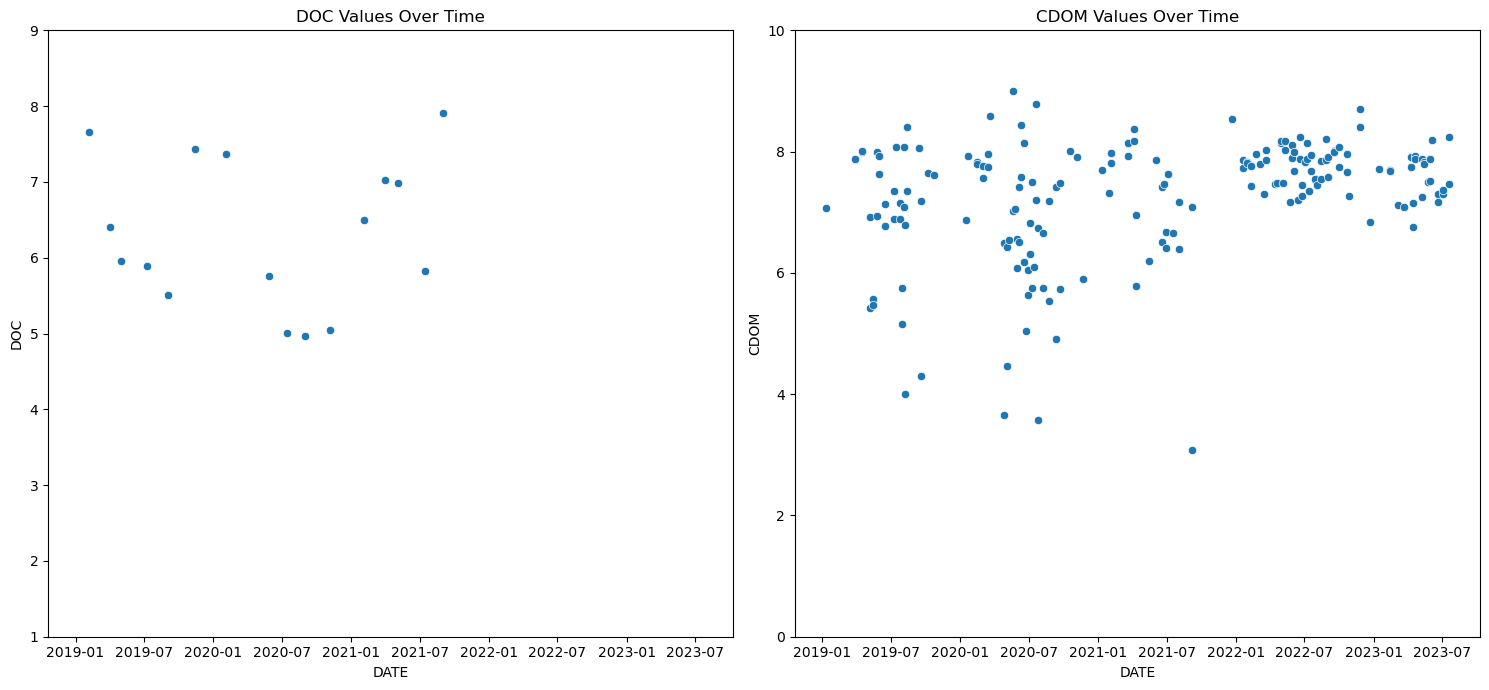

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data, x='date', y='DOC', ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('DOC')
ax1.set_ylim(1,9)

ax1.set_title('DOC Values Over Time')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('CDOM')
ax2.set_ylim(0,10)
ax2.set_title('CDOM Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

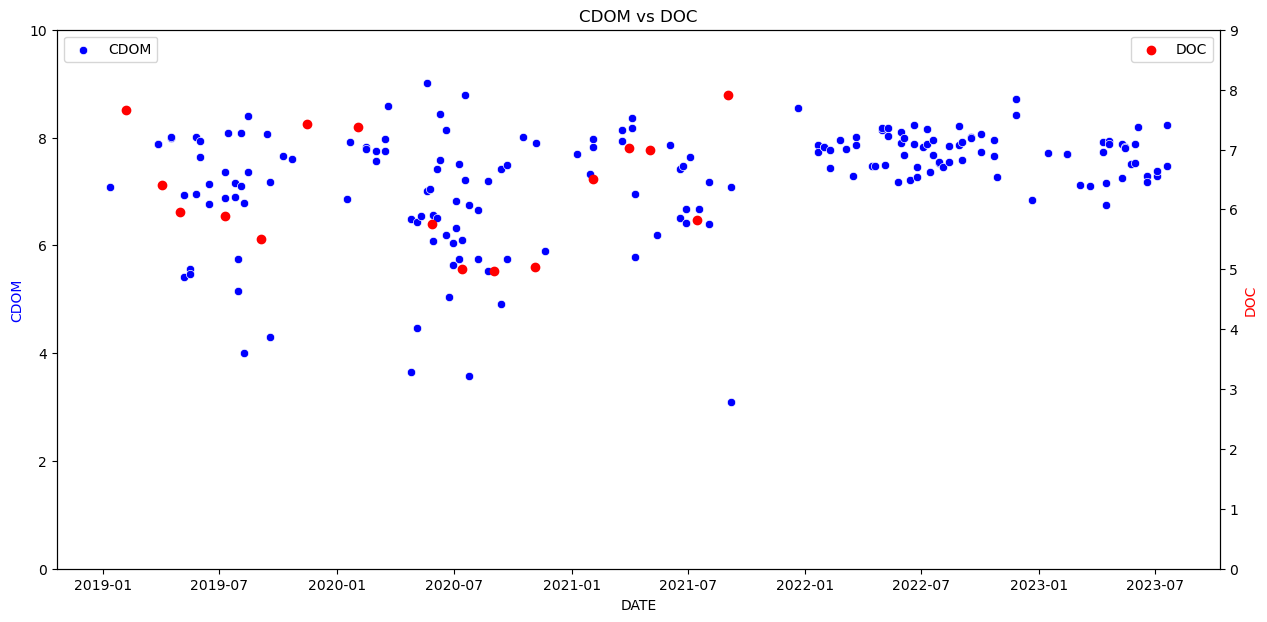

In [161]:
# CDOM vs DOC Timeseries
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data['date'], data['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(0,10)  # Adjust the range for CDOM
ax2.set_ylim(0, 9)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

In [162]:
# Sort the doc DataFrame by date in ascending order
data = data.sort_values(by='date')

# Sort the keys in the 'date' column of df(CDOM) in ascending order
df.sort_values('date', inplace=True)

# Convert 'date' column in df(CDOM) to datetime dtype
df['date'] = pd.to_datetime(df['date'])

# Perform inner merge with five-day window
merged_inner = pd.merge_asof(df, data, left_on='date', right_on='date', tolerance=pd.Timedelta(days=5))

# Get rid of the null values from doc
merged_inner = merged_inner.dropna()

print(merged_inner)




          date          CDOM  SITE_ID       DOC
5   2019-05-06      6.929021  1A1-103  5.958300
6   2019-05-06      5.421134  1A1-103  5.958300
15  2019-07-10      7.355293  1A1-103  5.888300
16  2019-07-10      6.881957  1A1-103  5.888300
36  2019-11-17     14.090304  1A1-103  7.429081
37  2019-11-17  10811.068138  1A1-103  7.429081
55  2020-05-30      6.564109  1A1-103  5.758763
56  2020-05-30      6.072636  1A1-103  5.758763
70  2020-07-14      6.103464  1A1-103  5.007855
71  2020-07-19      7.206992  1A1-103  5.007855
72  2020-07-19      8.792159  1A1-103  5.007855
85  2020-11-06     10.528822  1A1-103  5.042800
86  2020-11-06      7.904980  1A1-103  5.042800
90  2021-02-04      7.969167  1A1-103  6.499600
91  2021-02-04      7.819880  1A1-103  6.499600
94  2021-04-05      8.365152  1A1-103  7.029300
95  2021-04-05      8.182949  1A1-103  7.029300
106 2021-07-19      6.665624  1A1-103  5.821500
109 2021-09-07      7.085899  1A1-103  7.912200
110 2021-09-07      3.087308  1A1-103  7

In [163]:
# Drop duplicate rows based on DOC column, keeping the first occurrence
merged_inner = merged_inner.drop_duplicates(subset=['DOC'])

# Print the updated DataFrame
#print(merged_inner)

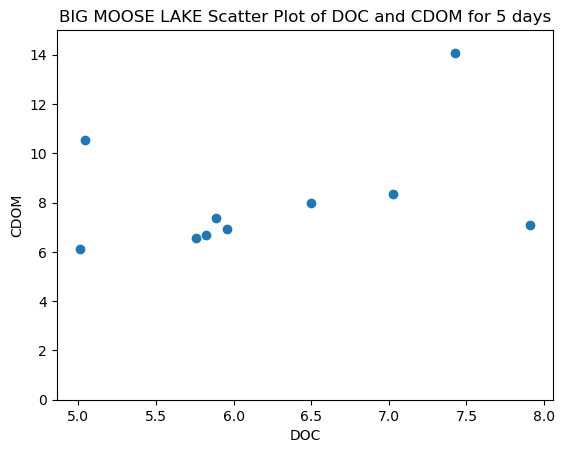

In [164]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(merged_inner['DOC'], merged_inner['CDOM'])
# Setting labels and title
plt.xlabel('DOC')
plt.ylabel('CDOM')
plt.title('BIG MOOSE LAKE Scatter Plot of DOC and CDOM for 5 days')
plt.ylim(0,15)
# Displaying the plot
plt.show()

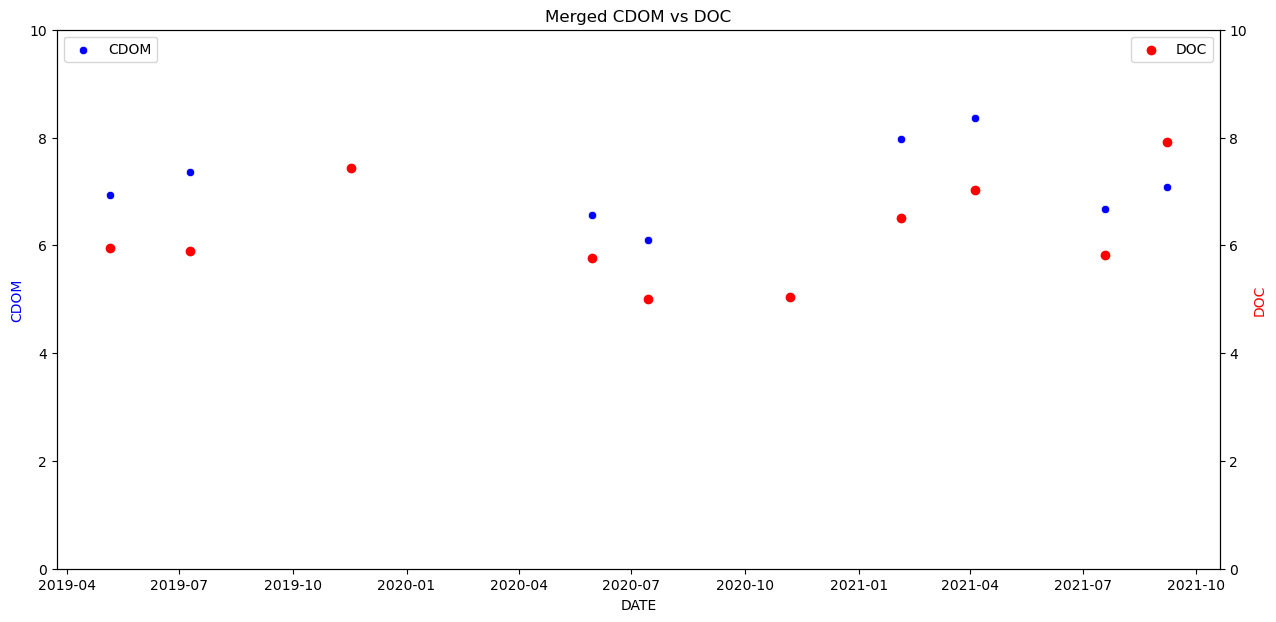

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=merged_inner, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(0, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

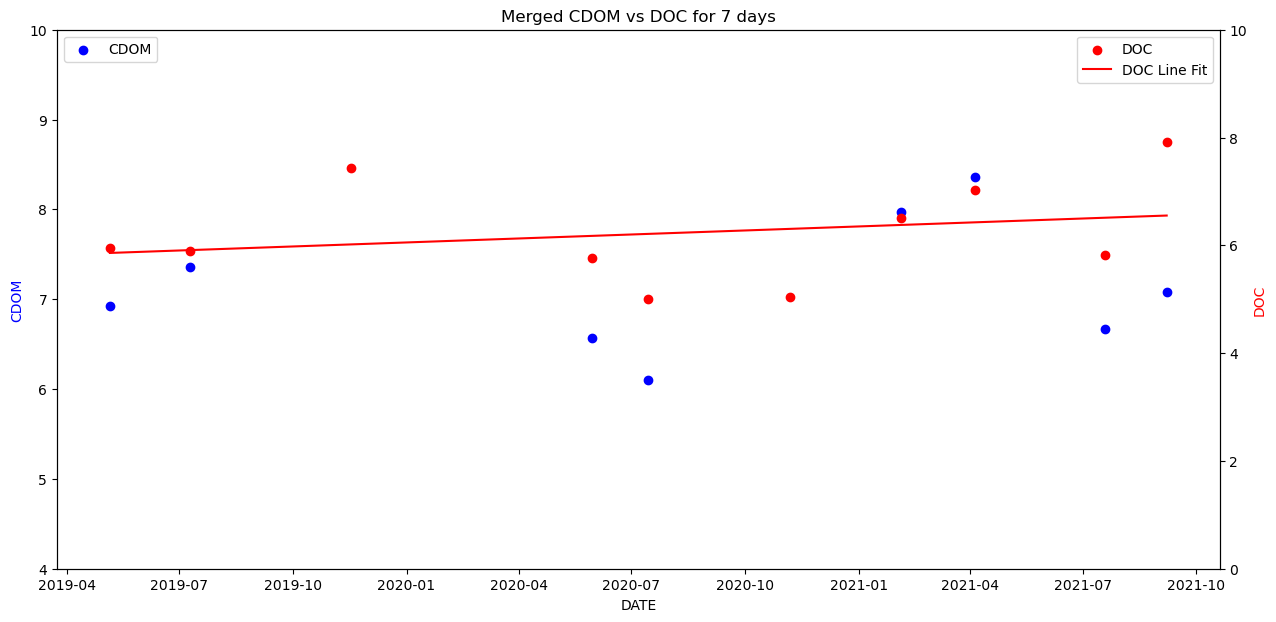

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert the date values to numeric format
merged_inner['date_numeric'] = pd.to_numeric(merged_inner['date']).astype(float)

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Matplotlib scatter plot 
ax.scatter(merged_inner['date'], merged_inner['CDOM'], label='CDOM', color='blue')


# Create a twin Axes object for DOC
ax2 = ax.twinx()
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')


# Calculate the linear regression line for CDOM
cdom_x = merged_inner['date_numeric']
cdom_y = merged_inner['CDOM']
cdom_slope, cdom_intercept = np.polyfit(cdom_x, cdom_y, 1)
cdom_line = cdom_slope * cdom_x + cdom_intercept
#ax.plot(merged_inner['date'], cdom_line, color='blue', label='CDOM Line Fit')

# Calculate the linear regression line for DOC
doc_x = merged_inner['date_numeric']
doc_y = merged_inner['DOC']
doc_slope, doc_intercept = np.polyfit(doc_x, doc_y, 1)
doc_line = doc_slope * doc_x + doc_intercept
ax2.plot(merged_inner['date'], doc_line, color='red', label='DOC Line Fit')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC for 7 days')

# Set different ranges for the y-axes
ax.set_ylim(4, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

# Reflectance Values

In [167]:
def reflectance(img): 
    #img is used to calculate the mean of specific bands indicated by STD_NAMES
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return ee.Feature(None, {'date': img.date().format(), 'reflectance': reflectance_values})

s2_reflectance = s2.map(reflectance)
s2_list = s2_reflectance.reduceColumns(ee.Reducer.toList(2), ['date', 'reflectance']).values().get(0)
df_s2_reflectance = pd.DataFrame(s2_list.getInfo(), columns=['date', 'reflectance'])

# Convert date column to datetime and extract date only
df_s2_reflectance['date'] = pd.to_datetime(df_s2_reflectance['date']).dt.date

# Set the reflectance column values to a dictionary
df_s2_reflectance['reflectance'] = df_s2_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})
df_s2_reflectance

,date,reflectance
0,2019-01-11,{}
1,2019-01-11,"{'Aerosols': 5352.301864026751, 'Blue': 5974.1..."
2,2019-02-25,{}
3,2019-03-27,"{'Aerosols': 6701.580454096742, 'Blue': 7940.6..."
4,2019-03-27,"{'Aerosols': 8715.188733375622, 'Blue': 9067.8..."
5,2019-04-01,{}
6,2019-04-16,"{'Aerosols': 3251.4452122408698, 'Blue': 3887...."
7,2019-04-16,"{'Aerosols': 4015.6501435621008, 'Blue': 4164...."
8,2019-05-06,"{'Aerosols': 2852.5760333127696, 'Blue': 3390...."
9,2019-05-06,"{'Aerosols': 873.2274700740088, 'Blue': 725.63..."


In [168]:
# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)



          Band   Reflectance        Date
0     Aerosols   5352.301864  2019-01-11
1         Blue   5974.192360  2019-01-11
2        Green   5596.661501  2019-01-11
3          Red   5507.644419  2019-01-11
4     RedEdge1   5533.549726  2019-01-11
5     RedEdge2   5516.074105  2019-01-11
6     RedEdge4   5695.592688  2019-01-11
7          NIR   5184.354298  2019-01-11
8        SWIR1   1002.412262  2019-01-11
9     Aerosols   6701.580454  2019-03-27
10        Blue   7940.644250  2019-03-27
11       Green   7867.181392  2019-03-27
12         Red   7861.520977  2019-03-27
13    RedEdge1   8143.998643  2019-03-27
14    RedEdge2   7934.054664  2019-03-27
15    RedEdge4   7449.559847  2019-03-27
16         NIR   6966.579714  2019-03-27
17       SWIR1    461.985686  2019-03-27
18    Aerosols   8715.188733  2019-03-27
19        Blue   9067.871269  2019-03-27
20       Green   9004.836995  2019-03-27
21         Red   9067.784191  2019-03-27
22    RedEdge1   9187.246075  2019-03-27
23    RedEdge2  

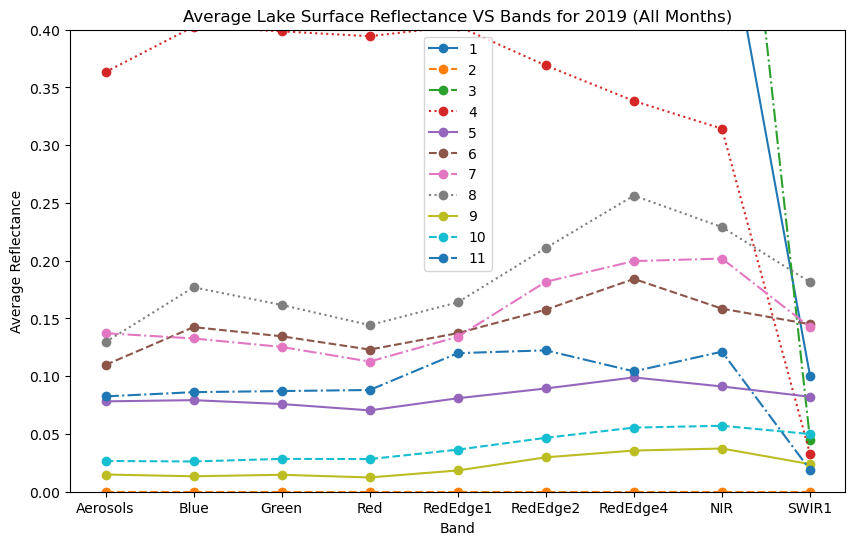

In [169]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in data_by_month.items():
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    
    average_reflectance_values = []
    for band in STD_NAMES:
        reflectance_values = [data['reflectance'][i] for i in range(len(data['band'])) if data['band'][i] == band]
        
        if len(reflectance_values) > 0:
            average_reflectance = sum(reflectance_values) / len(reflectance_values)
            average_reflectance_values.append(average_reflectance)
        else:
            average_reflectance_values.append(0)
    
    plt.plot(STD_NAMES, average_reflectance_values, linestyle=line_style, marker='o', label=month)
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.4)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()




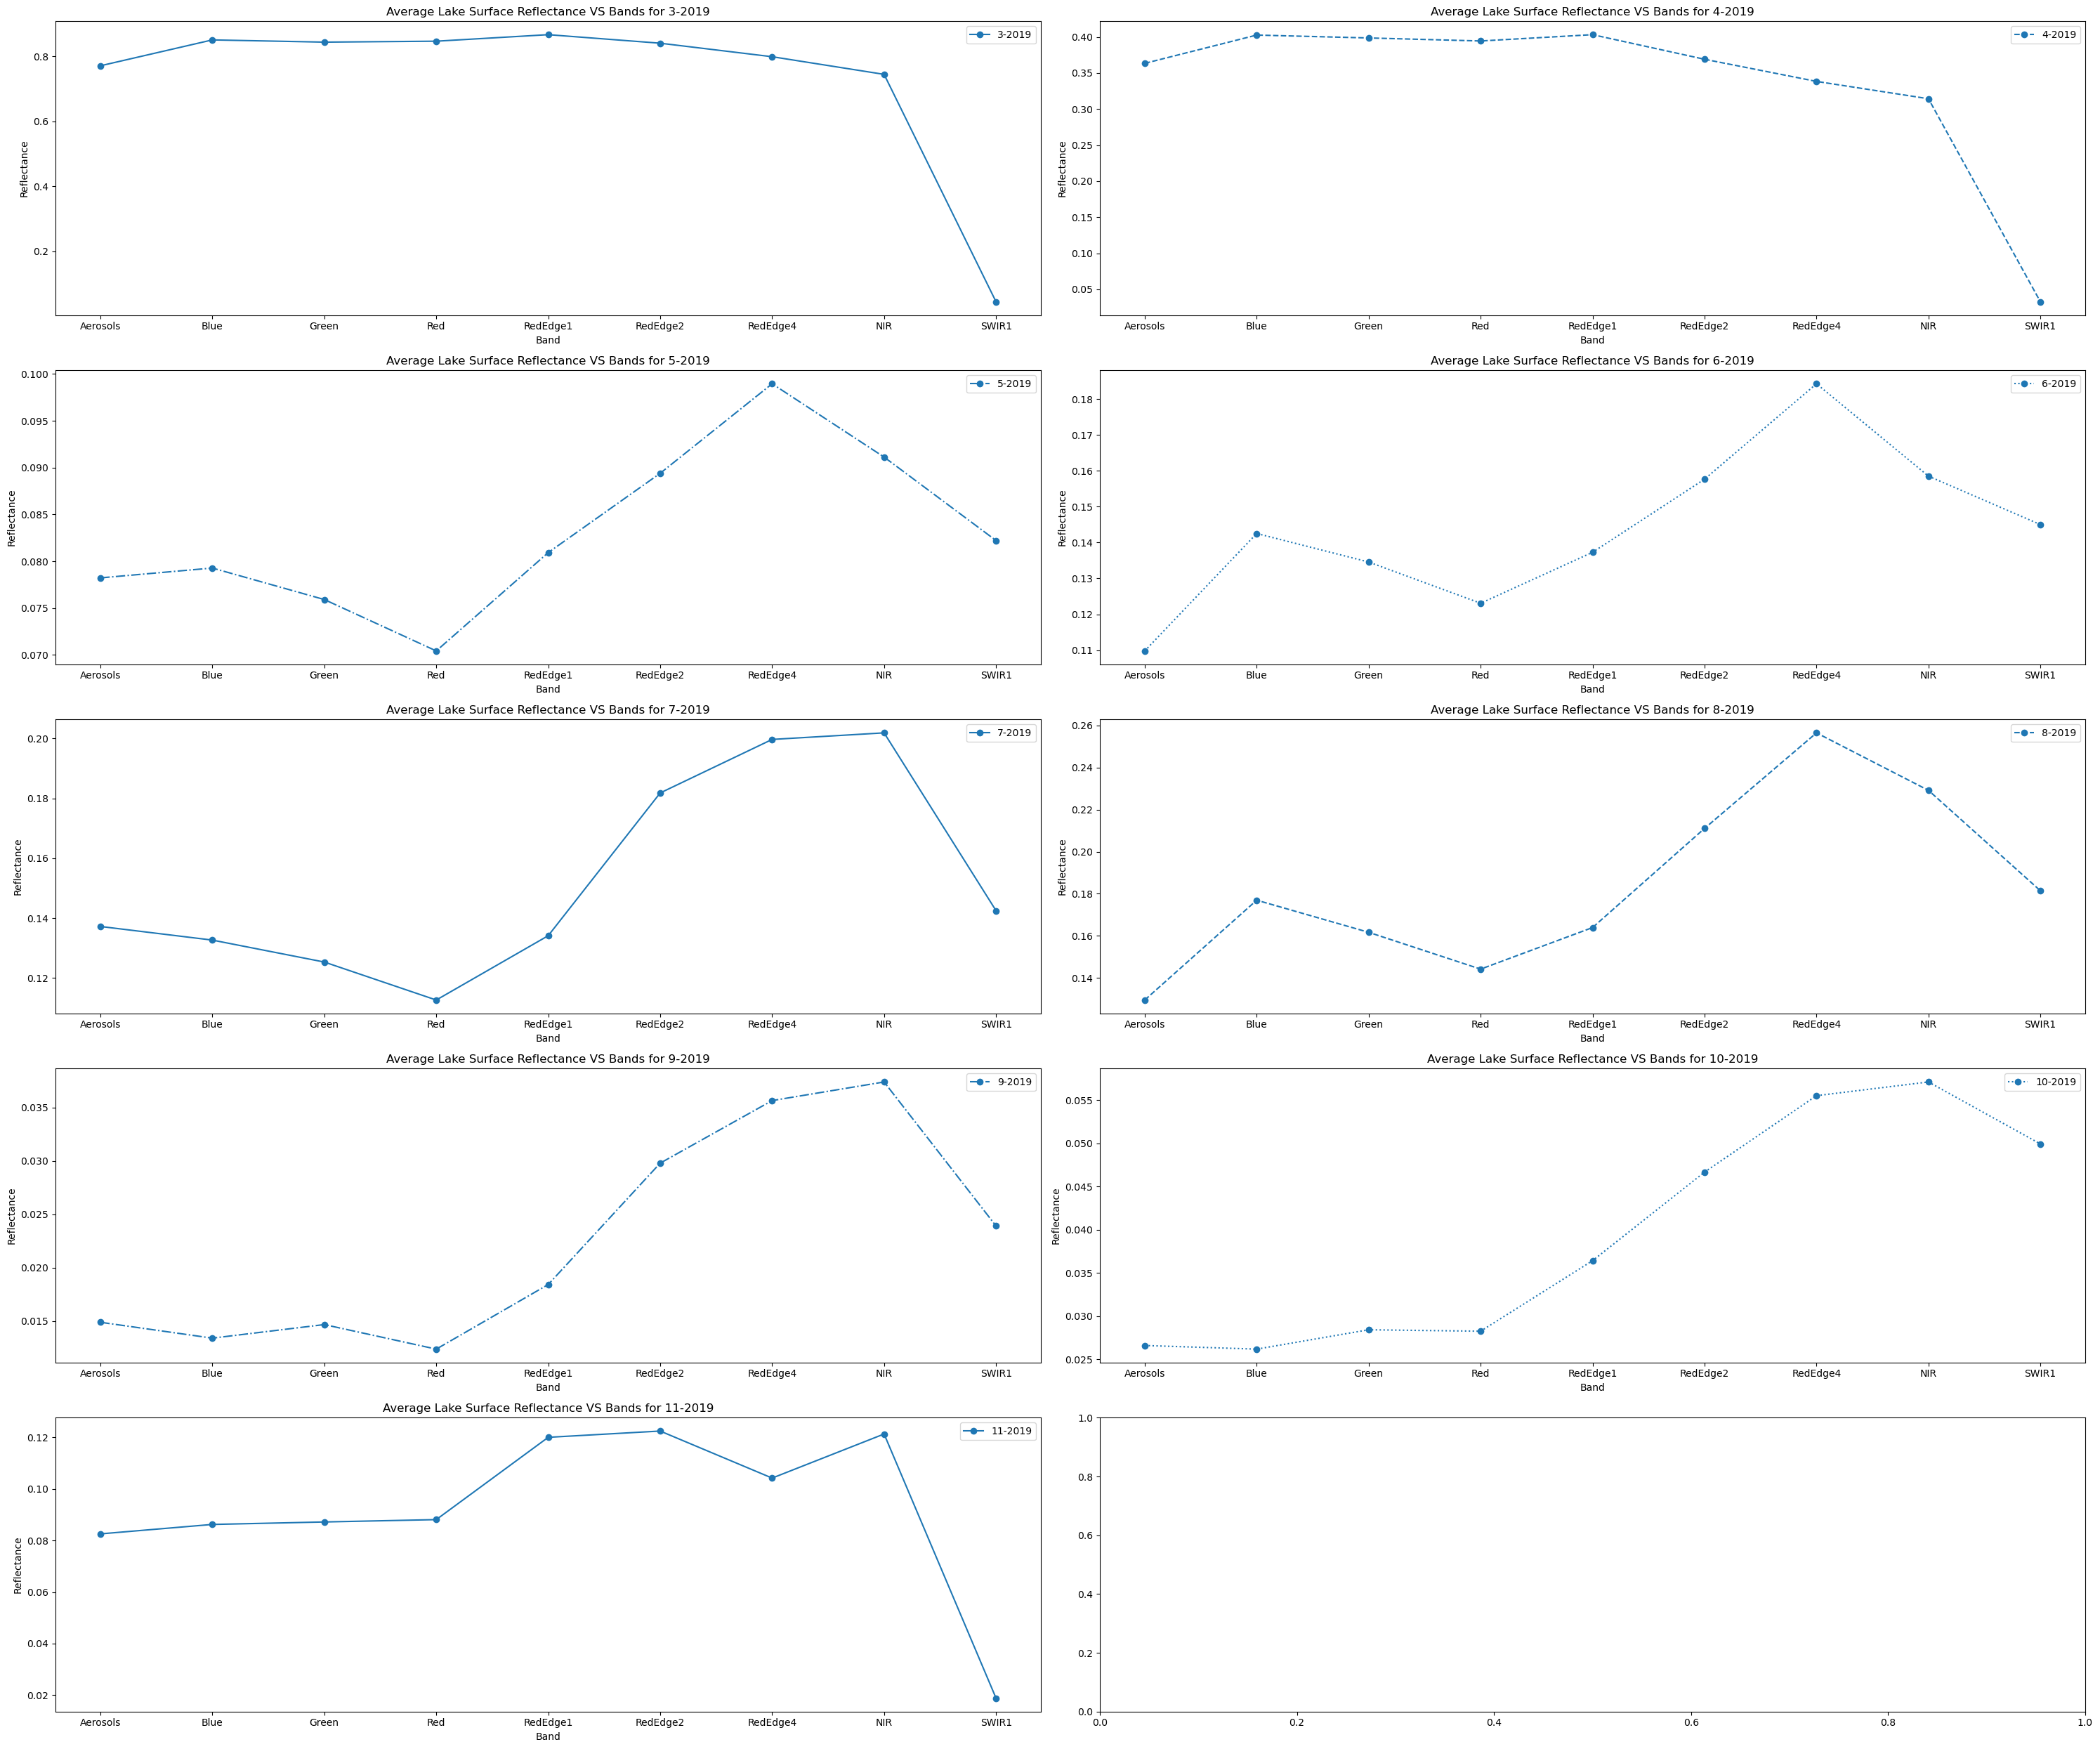

In [170]:
import numpy as np

data_by_month = {}

# Iterate over the dataframe rows
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    # Filter data for specific months
    if year == 2019 and date.month in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {band: [] for band in STD_NAMES}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month][band].append(value)
                else:
                    data_by_month[month][band].append(np.nan)

# Calculate the average reflectance values for each band within each month
averages_by_month = {
    month: {band: np.nanmean(values) for band, values in data.items()}
    for month, data in data_by_month.items()
}

# Define plot parameters
line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)

# Calculate the number of rows and columns for the subplots
num_months = len(data_by_month)
num_cols = 2  # Number of subplots per row
num_rows = (num_months + num_cols - 1) // num_cols

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 5 * num_rows))

# Flatten the axs array to iterate over subplots
axs = axs.flatten()

# Iterate over the data for each month
for i, (month, data) in enumerate(averages_by_month.items()):
    line_style = line_styles[i % num_styles]  # Cycle through line styles
    
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel('Reflectance')
    axs[i].set_title(f'Average Lake Surface Reflectance VS Bands for {month}-2019')
    
    bands = list(data.keys())
    reflectance_values = list(data.values())
    axs[i].plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}-2019')
    
    axs[i].legend()

plt.tight_layout()
plt.show()





# Each Band Reflectance Over Time

In [171]:
# x-axis: Time, y-axis: Bands 
# Do Each bands over Time 
# Do all the Years 

In [172]:
import pandas as pd

# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)

          Band   Reflectance        Date
0     Aerosols   5352.301864  2019-01-11
1         Blue   5974.192360  2019-01-11
2        Green   5596.661501  2019-01-11
3          Red   5507.644419  2019-01-11
4     RedEdge1   5533.549726  2019-01-11
5     RedEdge2   5516.074105  2019-01-11
6     RedEdge4   5695.592688  2019-01-11
7          NIR   5184.354298  2019-01-11
8        SWIR1   1002.412262  2019-01-11
9     Aerosols   6701.580454  2019-03-27
10        Blue   7940.644250  2019-03-27
11       Green   7867.181392  2019-03-27
12         Red   7861.520977  2019-03-27
13    RedEdge1   8143.998643  2019-03-27
14    RedEdge2   7934.054664  2019-03-27
15    RedEdge4   7449.559847  2019-03-27
16         NIR   6966.579714  2019-03-27
17       SWIR1    461.985686  2019-03-27
18    Aerosols   8715.188733  2019-03-27
19        Blue   9067.871269  2019-03-27
20       Green   9004.836995  2019-03-27
21         Red   9067.784191  2019-03-27
22    RedEdge1   9187.246075  2019-03-27
23    RedEdge2  

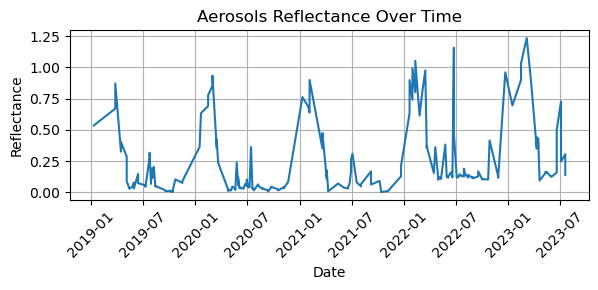

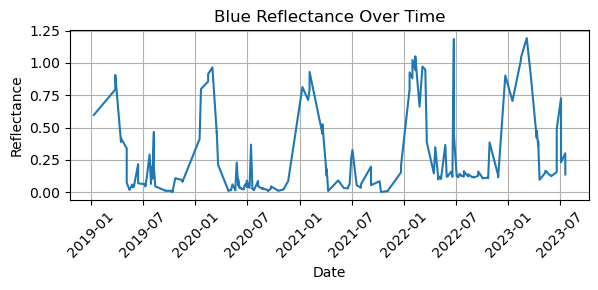

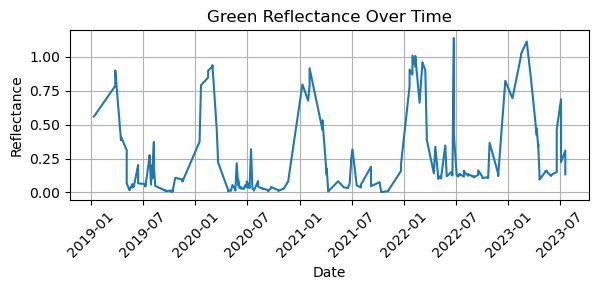

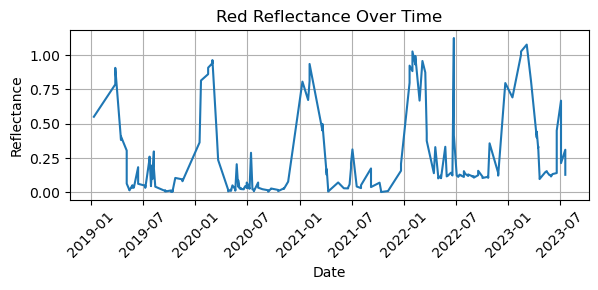

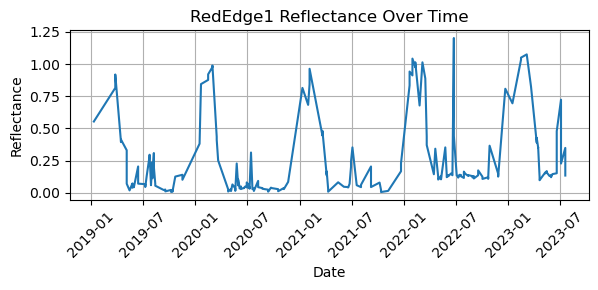

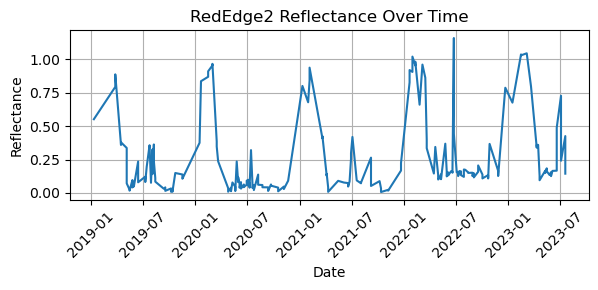

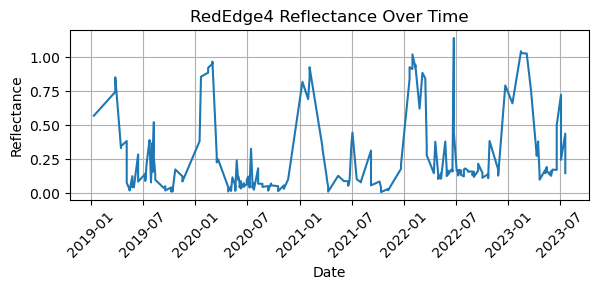

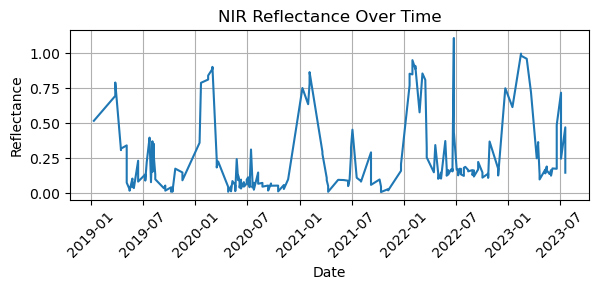

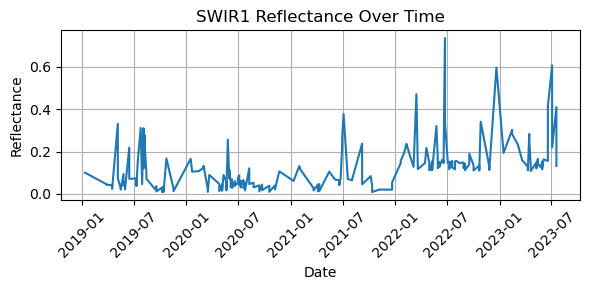

In [173]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Loop through each band and create a separate plot for each
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    plt.figure(figsize=(6, 3))  # Adjust the figsize to make the plot smaller
    plt.plot(df_band['Date'], df_band['Reflectance'])
    plt.xlabel('Date')
    plt.ylabel('Reflectance')
    plt.title(f'{band} Reflectance Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


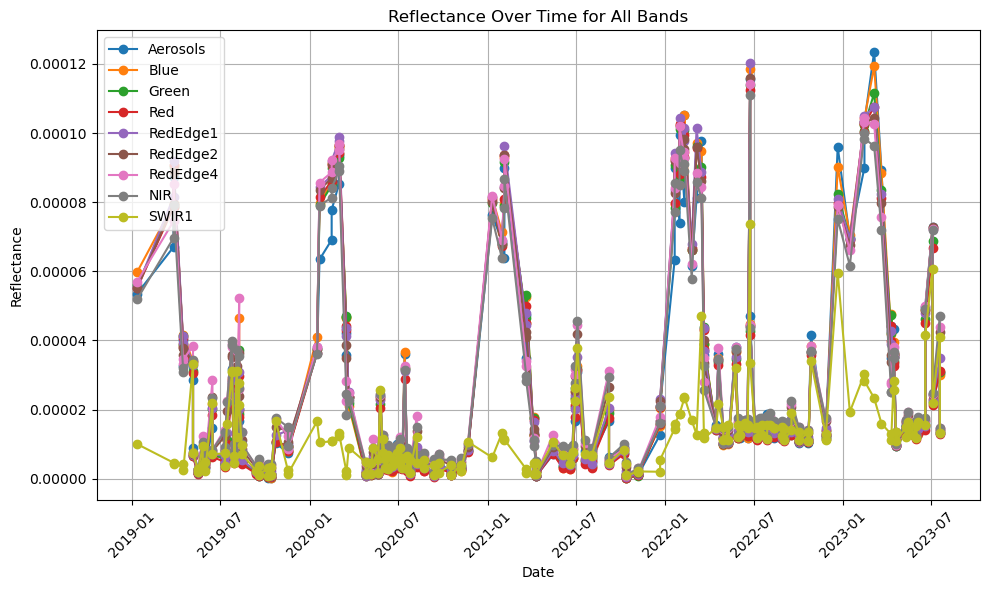

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], marker='o', label=band)

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time for All Bands')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


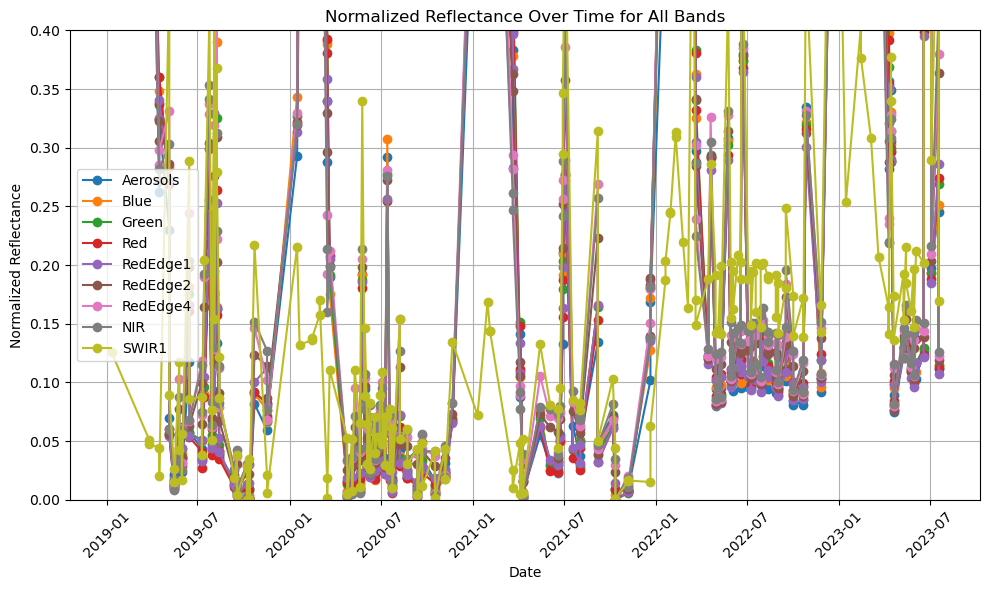

In [175]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot larger
for band in bands:
    df_band = df_data[df_data['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, marker='o', label=band)

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time for All Bands')
plt.grid(True)
plt.ylim(0,0.4)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


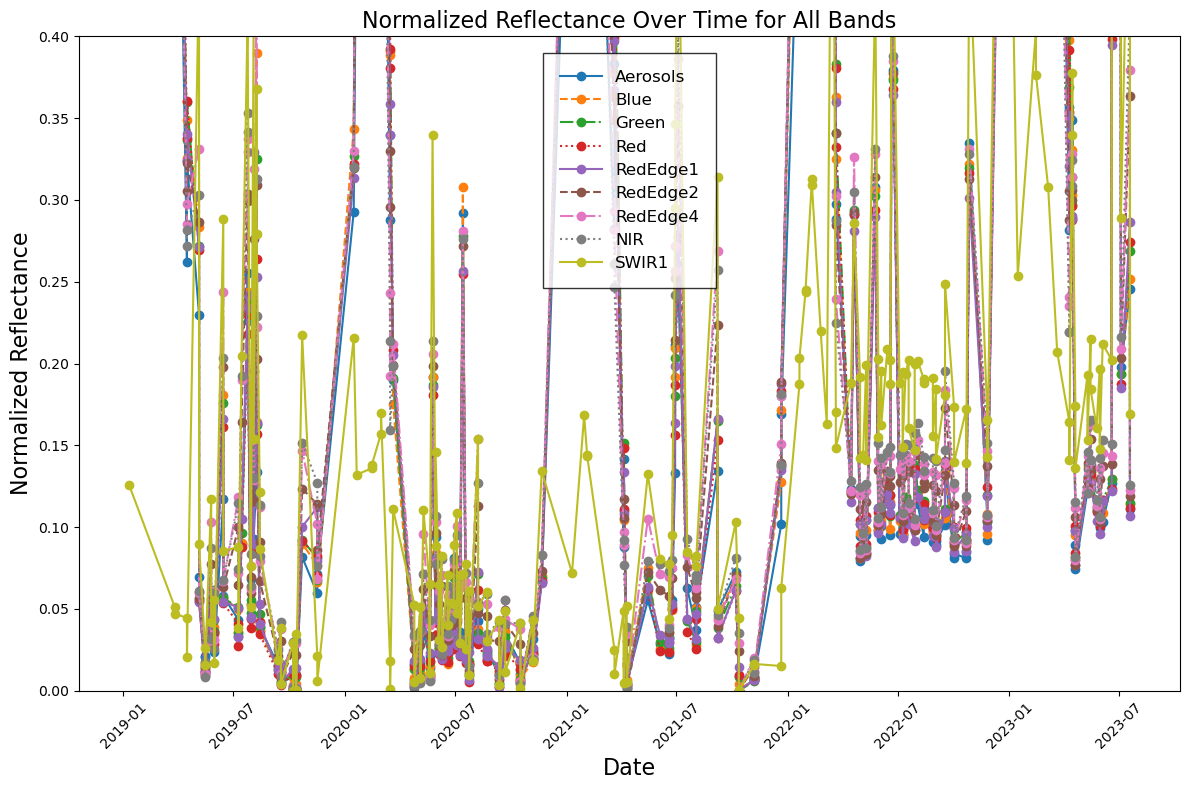

In [176]:
import pandas as pd
import matplotlib.pyplot as plt

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Get a list of unique bands from the DataFrame
bands = df_data['Band'].unique()

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(12, 8))  # Adjust the figsize to make the plot larger
line_styles = ['-', '--', '-.', ':']  # Different line styles for each band

for idx, band in enumerate(bands):
    df_band = df_data[df_data['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, marker='o', label=band, linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date', fontsize=16)  # Increase text size for x-axis label
plt.ylabel('Normalized Reflectance', fontsize=16)  # Increase text size for y-axis label
plt.title('Normalized Reflectance Over Time for All Bands', fontsize=16)  # Increase text size for title
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.legend(prop={'size': 12}, frameon=True, edgecolor='black', fancybox=False, borderpad=1, borderaxespad=1, handlelength=2.5)  # Make the border bold
plt.tight_layout()
plt.grid(False)  # Remove the grid
plt.show()


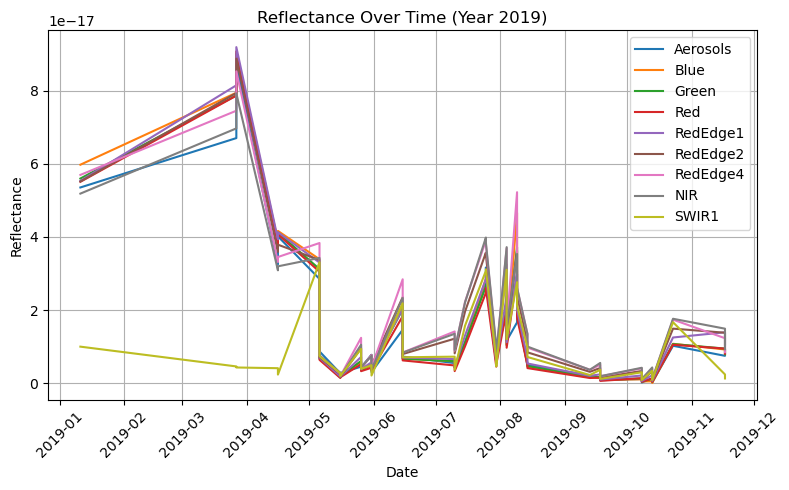

In [177]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Filter data for the year 2019
df_data_2019 = df_data[df_data['Date'].dt.year == 2019]

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
for band in df_data_2019['Band'].unique():
    df_band = df_data_2019[df_data_2019['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], label=f'{band}')

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time (Year 2019)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


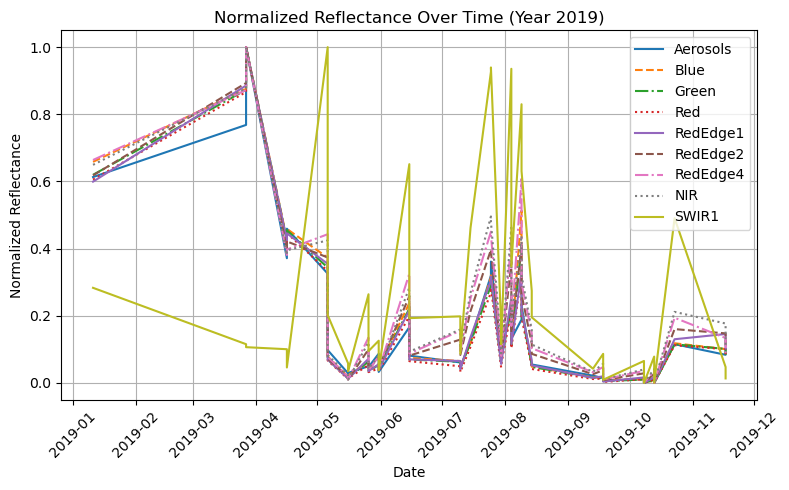

In [178]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Filter data for the year 2016
df_data_2019 = df_data[df_data['Date'].dt.year == 2019]

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed

# Define a list of different line styles for each band
line_styles = ['-', '--', '-.', ':']

# Get unique bands in the data
unique_bands = df_data_2019['Band'].unique()

# Plot each band with a different line style
for idx, band in enumerate(unique_bands):
    df_band = df_data_2019[df_data_2019['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, label=f'{band}', linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time (Year 2019)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


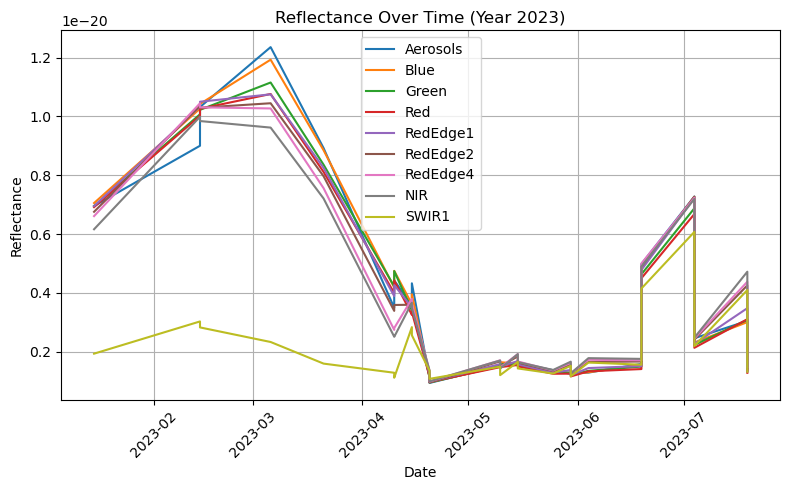

In [179]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Divide reflectance values by 10000 to convert from DN to reflectance
df_data['Reflectance'] /= 10000

# Filter data for the year 2016
df_data_2023 = df_data[df_data['Date'].dt.year == 2023]

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
for band in df_data_2023['Band'].unique():
    df_band = df_data_2023[df_data_2023['Band'] == band]
    plt.plot(df_band['Date'], df_band['Reflectance'], label=f'{band}')

plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.title('Reflectance Over Time (Year 2023)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


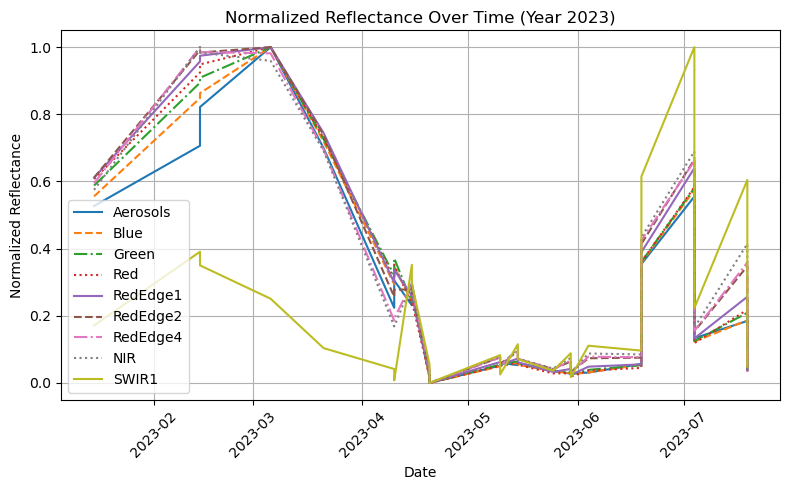

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to pandas datetime type
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Filter data for the year 2016
df_data_2023 = df_data[df_data['Date'].dt.year == 2023]

# Min-Max normalization function
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(8, 5))  # Adjust the figsize as needed

# Define a list of different line styles for each band
line_styles = ['-', '--', '-.', ':']

# Get unique bands in the data
unique_bands = df_data_2023['Band'].unique()

# Plot each band with a different line style
for idx, band in enumerate(unique_bands):
    df_band = df_data_2023[df_data_2023['Band'] == band]
    normalized_reflectance = min_max_normalize(df_band['Reflectance'])
    plt.plot(df_band['Date'], normalized_reflectance, label=f'{band}', linestyle=line_styles[idx % len(line_styles)])

plt.xlabel('Date')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Reflectance Over Time (Year 2023)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
